In [1]:
import tensorflow as tf
from Compute_Jacobian import jacobian # Please download 'Compute_Jacobian.py' in the repository 
import numpy as np
import timeit
from scipy.interpolate import griddata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os



os.environ["KMP_WARNINGS"] = "FALSE" 
import timeit

import sys

import scipy
import scipy.io
import time


In [2]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

# Define the exact solution and its derivatives
def u(x, a, c):
    """
    :param x: x = (t, x)
    """
    t = x[:,0:1]
    x = x[:,1:2]
    return np.sin(np.pi * x) * np.cos(c * np.pi * t) + a * np.sin(2 * c * np.pi* x) * np.cos(4 * c  * np.pi * t)

def u_t(x,a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_t = -  c * np.pi * np.sin(np.pi * x) * np.sin(c * np.pi * t) -  a * 4 * c * np.pi * np.sin(2 * c * np.pi* x) * np.sin(4 * c * np.pi * t)
    return u_t

def u_tt(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_tt = -(c * np.pi)**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) - a * (4 * c * np.pi)**2 *  np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return u_tt

def u_xx(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_xx = - np.pi**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) -  a * (2 * c * np.pi)** 2 * np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return  u_xx


def r(x, a, c):
    return u_tt(x, a, c) - c**2 * u_xx(x, a, c)

def operator(u, t, x, c, sigma_t=1.0, sigma_x=1.0):
    u_t = tf.gradients(u, t)[0] / sigma_t
    u_x = tf.gradients(u, x)[0] / sigma_x
    u_tt = tf.gradients(u_t, t)[0] / sigma_t
    u_xx = tf.gradients(u_x, x)[0] / sigma_x
    residual = u_tt - c**2 * u_xx
    return residual



In [3]:
class PINN:
    # Initialize the class
    def __init__(self, layers, operator, ics_sampler, bcs_sampler, res_sampler, c, kernel_size , sess):
        # Normalization 
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_t, self.sigma_t = self.mu_X[0], self.sigma_X[0]
        self.mu_x, self.sigma_x = self.mu_X[1], self.sigma_X[1]

        self.activFun = 'xsig'
        # Samplers
        self.operator = operator
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        self.sess = sess
        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # weights
        self.lam_u_val = np.array(2.0)
        self.lam_ut_val = np.array(2.0)
        self.lam_r_val = np.array(1.0)
        self.lam_bc1_val = np.array(2.0)
        self.lam_bc2_val = np.array(2.0)
      
        # Wave constant
        self.c = tf.constant(c, dtype=tf.float32)
        
        self.kernel_size = kernel_size # Size of the NTK matrix

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))

        # Define placeholders and computational graph
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        
        self.lam_u_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        self.lam_ut_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        # self.lam_r_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        self.lam_bc_tf = tf.placeholder(tf.float32, shape=self.lam_bc1_val.shape)
        # self.lam_bc2_tf = tf.placeholder(tf.float32, shape=self.lam_bc2_val.shape)
        

        self.u_pred = self.net_u(self.t_u_tf, self.x_u_tf)


        # Evaluate predictions
        self.u_ics_pred = self.net_u(self.t_ics_tf, self.x_ics_tf)
        self.u_bc1_pred = self.net_u(self.t_bc1_tf, self.x_bc1_tf)
        self.u_bc2_pred = self.net_u(self.t_bc2_tf, self.x_bc2_tf)

        self.r_pred = self.net_r(self.t_r_tf, self.x_r_tf)
        
        
        # Boundary loss and Initial loss
        self.loss_ics_u = tf.reduce_mean(tf.square(self.u_ics_tf - self.u_ics_pred)  +  tf.square( tf.gradients(self.u_ics_pred, self.t_ics_tf)[0] / self.sigma_t) )
        self.loss_bc1 = tf.reduce_mean(tf.square(self.u_bc1_pred)) + tf.reduce_mean(tf.square(self.u_bc2_pred))
        # self.loss_bc2 = tf.reduce_mean(tf.square(self.u_bc2_pred))

        # Residual loss
        self.loss_res = tf.reduce_mean(tf.square(self.r_pred))

        # Total loss
        self.loss =  self.loss_res + self.lam_bc_tf *( self.loss_bc1  )+ self.lam_u_tf * self.loss_ics_u # + self.lam_ut_tf * self.loss_ics_u_t 

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,  1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)
        
         # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,  dtype=tf.float32)

        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H, layers, weights, biases):
        num_layers = len(layers)
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            # H =  H*tf.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
              
        return H
################################################################################################
    # Forward pass for u
    def net_u(self, t, x):
        u = self.forward_pass(tf.concat([t, x], 1),  self.layers, self.weights, self.biases)
        return u

    # Forward pass for du/dt
    def net_u_t(self, t, x):
        u_t = tf.gradients(self.net_u(t, x), t)[0] / self.sigma_t
        return u_t

    # Forward pass for the residual
    def net_r(self, t, x):
        u = self.net_u(t, x)
        residual = self.operator(u, t, x, self.c, self.sigma_t,  self.sigma_x)
        return residual
    
    

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

        # Trains the model by minimizing the MSE loss

    def trainmb(self, nIter=10000, batch_size=128, log_NTK=False, update_lam=False):

        start_time = timeit.default_timer()
        for it in range(1 , nIter):
            # Fetch boundary mini-batches
            X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size // 3)
            X_bc1_batch, _ = self.fetch_minibatch(self.bcs_sampler[0], batch_size // 3)
            X_bc2_batch, _ = self.fetch_minibatch(self.bcs_sampler[1], batch_size // 3)
            
            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)
            # Define a dictionary for associating placeholders with data
            tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                       self.u_ics_tf: u_ics_batch,
                       self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                       self.t_bc2_tf: X_bc2_batch[:, 0:1], self.x_bc2_tf: X_bc2_batch[:, 1:2],
                       self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2],
                       self.lam_u_tf: self.lam_u_val,
                       self.lam_bc_tf: self.lam_bc1_val,
                    #    self.lam_bc2_tf: self.lam_bc2_val,
                       }

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time

                loss = self.sess.run(self.loss, tf_dict)
                loss_bc1 = self.sess.run(self.loss_bc1, tf_dict)
                # loss_bc2 = self.sess.run(self.loss_bc2, tf_dict)
                loss_ics_u = self.sess.run(self.loss_ics_u, tf_dict)
                loss_res = self.sess.run(self.loss_res, tf_dict)


                print('It: %d, Loss: %.3e,  loss_bc1: %.3e, loss_ics_u: %.3e,  Loss_res: %.3e , Time: %.2f' %(it, loss, loss_bc1 ,loss_ics_u , loss_res , elapsed))
                
 
                start_time = timeit.default_timer()
            
          
                if it % 100 == 0: 
                        alpha   = 10000
                        self.lam_bc1_val = alpha * loss_bc1
                        # self.lam_bc2_val = alpha * loss_bc2
                        self.lam_u_val = alpha * loss_ics_u

                        print('loss_bc1: {:.3e}'.format(self.lam_bc1_val))
                        # print('loss_bc2: {:.3e}'.format(self.lam_bc2_val))
                        print('loss_ics_u: {:.3e}'.format(self.lam_u_val))
                sys.stdout.flush()

    def train(self, nIter , bcbatch_size , ubatch_size):

        start_time = timeit.default_timer()

        # Fetch boundary mini-batches
        X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, bcbatch_size)
        X_bc1_batch, _ = self.fetch_minibatch(self.bcs_sampler[0], bcbatch_size )
        X_bc2_batch, _ = self.fetch_minibatch(self.bcs_sampler[1], bcbatch_size )
        
        # Fetch residual mini-batch
        X_res_batch, _ = self.fetch_minibatch(self.res_sampler, ubatch_size)
        # print("inside trainmb: " , X_res_batch.shape)
        # Define a dictionary for associating placeholders with data
        tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                    self.u_ics_tf: u_ics_batch,
                    self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                    self.t_bc2_tf: X_bc2_batch[:, 0:1], self.x_bc2_tf: X_bc2_batch[:, 1:2],
                    self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2],
                    self.lam_u_tf: self.lam_u_val,
                       self.lam_bc_tf: self.lam_bc1_val,
                    #    self.lam_bc2_tf: self.lam_bc2_val,
                    }
        
   
  
        for it in range(nIter):

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time

                loss = self.sess.run(self.loss, tf_dict)
                loss_bc1 = self.sess.run(self.loss_bc1, tf_dict)
                # loss_bc2 = self.sess.run(self.loss_bc2, tf_dict)
                loss_ics_u = self.sess.run(self.loss_ics_u, tf_dict)
                loss_res = self.sess.run(self.loss_res, tf_dict)

             
                print('It: %d, Loss: %.3e,  loss_bc1: %.3e, loss_ics_u: %.3e,  Loss_res: %.3e , Time: %.2f' %(it, loss, loss_bc1 ,loss_ics_u , loss_res , elapsed))
  
         
                if it % 100 == 0: 
                        alpha   = 10000
                        self.lam_bc1_val = alpha * loss_bc1
                        # self.lam_bc2_val = alpha * loss_bc2
                        self.lam_u_val = alpha * loss_ics_u

                        print('loss_bc1: {:.3e}'.format(self.lam_bc1_val))
                        # print('loss_bc2: {:.3e}'.format(self.lam_bc2_val))
                        print('loss_ics_u: {:.3e}'.format(self.lam_u_val))
                sys.stdout.flush()

                          

    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_u_tf: X_star[:, 0:1], self.x_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

        # Evaluates predictions at test points

    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_r_tf: X_star[:, 0:1], self.x_r_tf: X_star[:, 1:2]}
        r_star = self.sess.run(self.r_pred, tf_dict)
        return r_star
    
   ###############################################################################################################################################
   # 
   # ###############################################################################################################################################
   # 
   # ###############################################################################################################################################
   # 
   #  




In [4]:
#test_method(mtd , layers,  X_u, Y_u, X_r, Y_r ,  X_star , u_star , r_star  , nIter ,batch_size , bcbatch_size , ubatch_size)
def test_method(method , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size ):

    tf.reset_default_graph()
    gpu_options = tf.GPUOptions(visible_device_list="0")
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:
        # sess.run(init)

        model = PINN(layers, operator, ics_sampler, bcs_sampler, res_sampler, c, kernel_size , sess)
        # Train model
        start_time = time.time()

        if method =="full_batch":
            print("full_batch method is used")
            model.train(nIter  , bcbatch_size , ubatch_size  )
        elif method =="mini_batch":
            print("mini_batch method is used")
            model.trainmb(nIter, mbbatch_size)
        else:
            print("unknown method!")
        elapsed = time.time() - start_time

        # Predictions
        u_pred = model.predict_u(X_star)
        # Predictions

        sess.close()   

    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

    print('elapsed: {:.2e}'.format(elapsed))

    print('Relative L2 error_u: {:.2e}'.format(error_u))


    return [elapsed, error_u  ]

###############################################################################################################################################



In [5]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')



nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M4'
layers = [2, 500, 500, 500, 1]


nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
r_star = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        tf.reset_default_graph()
        gpu_options = tf.GPUOptions(visible_device_list="0")
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:
            # sess.run(init)

            model = PINN(layers, operator, ics_sampler, bcs_sampler, res_sampler, c, kernel_size , sess)
            # Train model
            start_time = time.time()

            if mtd =="full_batch":
                print("full_batch method is used")
                model.train(nIter  , bcbatch_size , ubatch_size  )
            elif mtd =="mini_batch":
                print("mini_batch method is used")
                model.trainmb(nIter, mbbatch_size)
            else:
                print("unknown method!")
            elapsed = time.time() - start_time

            # Predictions
            u_pred = model.predict_u(X_star)
            r_pred = model.predict_r(X_star)
            # Predictions

            sess.close()   

            error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
            error_r = np.linalg.norm(r_star - r_pred, 2)# / np.linalg.norm(r_star, 2)

            print('elapsed: {:.2e}'.format(elapsed))

            print('Relative L2 error_u: {:.2e}'.format(error_u))
            print('Relative L2 error_r: {:.2e}'.format(error_r))

        # print('elapsed: {:.2e}'.format(elapsed))
        # print('Relative L2 error_u: {:.2e}'.format(error_u))

        time_list.append(elapsed)
        error_u_list.append(error_u)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    # print("average of error_r_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat("./1DWave_database/"+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_"+str(iterations)+".mat" , result_dict)

###############################################################################################################################################


Method:  mini_batch
Epoch:  1







2023-11-27 18:55:39.395296: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 18:55:39.417200: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2023-11-27 18:55:39.417804: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56031460f270 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-27 18:55:39.417823: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-27 18:55:39.419833: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.





mini_batch method is used
It: 100, Loss: 8.963e-01,  loss_bc1: 7.200e-02, loss_ics_u: 3.759e-01,  Loss_res: 5.304e-04 , Time: 4.43
loss_bc1: 7.200e+02
loss_ics_u: 3.759e+03
It: 200, Loss: 7.041e+02,  loss_bc1: 1.428e-01, loss_ics_u: 1.303e-01,  Loss_res: 1.116e+02 , Time: 2.85
loss_bc1: 1.428e+03
loss_ics_u: 1.303e+03
It: 300, Loss: 2.095e+02,  loss_bc1: 5.992e-03, loss_ics_u: 1.209e-01,  Loss_res: 4.344e+01 , Time: 2.83
loss_bc1: 5.992e+01
loss_ics_u: 1.209e+03
It: 400, Loss: 1.366e+02,  loss_bc1: 6.111e-02, loss_ics_u: 1.045e-01,  Loss_res: 6.707e+00 , Time: 2.89
loss_bc1: 6.111e+02
loss_ics_u: 1.045e+03
It: 500, Loss: 1.449e+02,  loss_bc1: 3.814e-02, loss_ics_u: 1.041e-01,  Loss_res: 1.279e+01 , Time: 2.86
loss_bc1: 3.814e+02
loss_ics_u: 1.041e+03
It: 600, Loss: 1.868e+02,  loss_bc1: 3.799e-02, loss_ics_u: 1.594e-01,  Loss_res: 6.396e+00 , Time: 2.88
loss_bc1: 3.799e+02
loss_ics_u: 1.594e+03
It: 700, Loss: 2.767e+02,  loss_bc1: 7.289e-02, loss_ics_u: 1.300e-01,  Loss_res: 4.179e+

In [6]:
# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
# Predictions

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_r = np.linalg.norm(r_star - r_pred, 2)# / np.linalg.norm(r_star, 2)

# print('elapsed: {:.2e}'.format(elapsed))

print('Relative L2 error_u: {:.2e}'.format(error_u))
print('Relative L2 error_r: {:.2e}'.format(error_r))


Relative L2 error_u: 1.79e-01
Relative L2 error_r: 4.15e+01


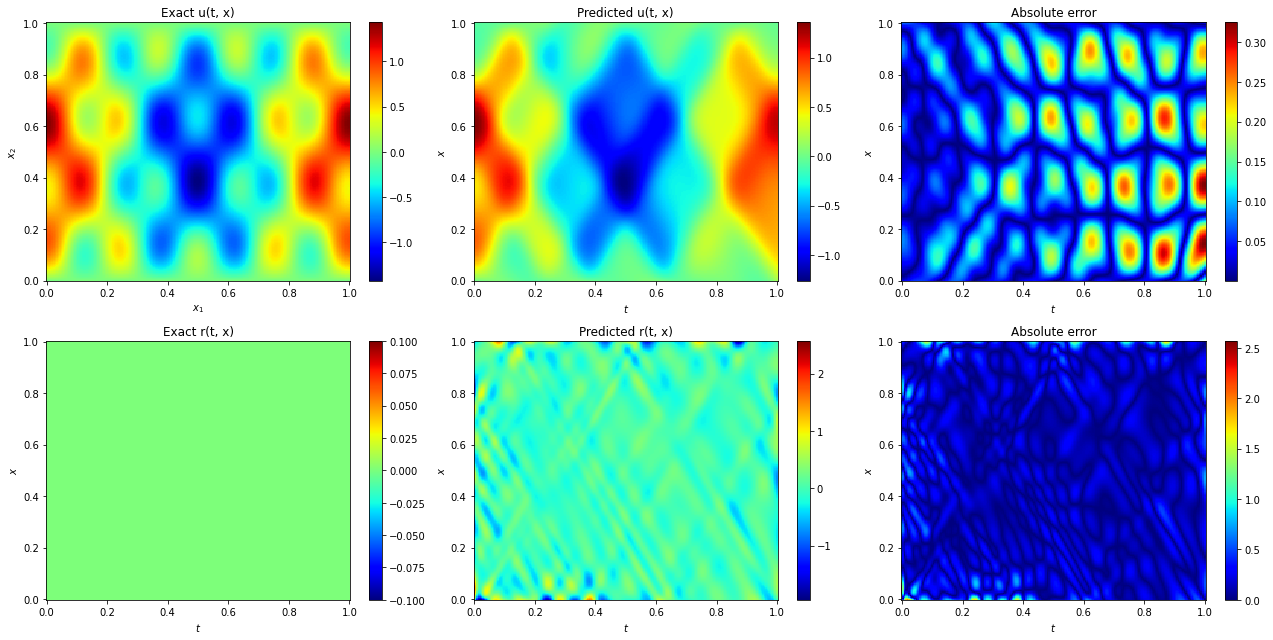

In [7]:
r_pred =r_pred.reshape(200,200)

U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
r_star = griddata(X_star, r_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
# R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t, x, r_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t, x, r_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t, x, np.abs(r_star - r_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

In [6]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')



nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M4'
layers = [2, 500, 500, 500, 1]


nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
r_star = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        [elapsed, error_u] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size )


        print('elapsed: {:.2e}'.format(elapsed))
        print('Relative L2 error_u: {:.2e}'.format(error_u))

        time_list.append(elapsed)
        error_u_list.append(error_u)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    # print("average of error_r_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat("./1DWave_database/"+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_"+str(iterations)+".mat" , result_dict)

###############################################################################################################################################


Method:  mini_batch
Epoch:  1
mini_batch method is used
It: 100, Loss: 9.238e-01,  loss_bc1: 6.848e-02, loss_ics_u: 3.931e-01,  Loss_res: 6.576e-04 , Time: 4.89
It: 200, Loss: 6.458e-01,  loss_bc1: 7.923e-02, loss_ics_u: 2.403e-01,  Loss_res: 6.826e-03 , Time: 3.53
It: 300, Loss: 6.600e-01,  loss_bc1: 8.652e-02, loss_ics_u: 2.341e-01,  Loss_res: 1.875e-02 , Time: 3.44
It: 400, Loss: 5.494e-01,  loss_bc1: 6.093e-02, loss_ics_u: 2.009e-01,  Loss_res: 2.586e-02 , Time: 3.43
It: 500, Loss: 5.235e-01,  loss_bc1: 4.314e-02, loss_ics_u: 2.099e-01,  Loss_res: 1.742e-02 , Time: 3.35
It: 600, Loss: 4.532e-01,  loss_bc1: 4.553e-02, loss_ics_u: 1.763e-01,  Loss_res: 9.461e-03 , Time: 3.27
It: 700, Loss: 4.660e-01,  loss_bc1: 4.488e-02, loss_ics_u: 1.662e-01,  Loss_res: 4.375e-02 , Time: 3.38
It: 800, Loss: 4.010e-01,  loss_bc1: 5.502e-02, loss_ics_u: 1.294e-01,  Loss_res: 3.213e-02 , Time: 3.22
It: 900, Loss: 3.889e-01,  loss_bc1: 4.886e-02, loss_ics_u: 1.423e-01,  Loss_res: 6.523e-03 , Time: 3.26

In [ ]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')



nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M4'
layers = [2, 500, 500, 500, 1]


nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
r_star = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        [elapsed, error_u] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size )


        print('elapsed: {:.2e}'.format(elapsed))
        print('Relative L2 error_u: {:.2e}'.format(error_u))

        time_list.append(elapsed)
        error_u_list.append(error_u)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    # print("average of error_r_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat("./1DWave_database/"+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_"+str(iterations)+".mat" , result_dict)

###############################################################################################################################################


In [ ]:

import scipy.io

mode = 'M4'
mbbatch_size = 128
ubatch_size = 5000
bcbatch_size = 500
iterations = 40000

time_list = []
error_u_list = []
error_v_list = []
error_p_list = []
    
methods = ["mini_batch" , "full_batch"]
result_dict =  dict((mtd, []) for mtd in methods)

##Mini Batch
time_list = []
error_u_list = [ ]


result_dict["mini_batch"] = [time_list ,error_u_list]

print("\n\nMethod: ", mtd)
print("\naverage of time_list:" , sum(time_list) / len(time_list) )
print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )

##Full Batch
time_list = []
error_u_list = [ ]
error_v_list = []
error_p_list = []

result_dict["full_batch"] = [time_list ,error_u_list ,error_v_list ,  error_p_list]

print("\n\nMethod: ", mtd)
print("\naverage of time_list:" , sum(time_list) / len(time_list) )
print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
print("average of error_v_list:" , sum(error_v_list) / len(error_v_list) )
print("average of error_p_list:" , sum(error_p_list) / len(error_p_list) )


scipy.io.savemat("./dataset/1DWave_database_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_"+str(bcbatch_size)+"_"+str(iterations)+".mat" , result_dict)



In [ ]:
# Train model
itertaions = 80001
log_NTK = True # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK 



**Training Loss**

In [ ]:
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log
loss_u_t_ics = model.loss_ut_ics_log

fig = plt.figure(figsize=(6, 5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{u}$')
plt.plot(loss_u_t_ics, label='$\mathcal{L}_{u_t}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

**Model Prediction**

In [ ]:


# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: %e' % (error_u))

In [ ]:
U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
r_star = griddata(X_star, r_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t, x, r_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t, x, R_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t, x, np.abs(r_star - R_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

**NTK Eigenvalues**

In [ ]:
# Create empty lists for storing the eigenvalues of NTK
lam_K_u_log = []
lam_K_ut_log = []
lam_K_r_log = []

# Restore the NTK
K_u_list = model.K_u_log
K_ut_list = model.K_ut_log
K_r_list = model.K_r_log

K_list = []
    
for k in range(len(K_u_list)):
    K_u = K_u_list[k]
    K_ut = K_ut_list[k]
    K_r = K_r_list[k]
    
    # Compute eigenvalues
    lam_K_u, _ = np.linalg.eig(K_u)
    lam_K_ut, _ = np.linalg.eig(K_ut)
    lam_K_r, _ = np.linalg.eig(K_r)
    # Sort in descresing order
    lam_K_u = np.sort(np.real(lam_K_u))[::-1]
    lam_K_ut = np.sort(np.real(lam_K_ut))[::-1]
    lam_K_r = np.sort(np.real(lam_K_r))[::-1]
    
    # Store eigenvalues
    lam_K_u_log.append(lam_K_u)
    lam_K_ut_log.append(lam_K_ut)
    lam_K_r_log.append(lam_K_r)

In [ ]:
#  Eigenvalues of NTK
fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)

plt.plot(lam_K_u_log[0], label = '$n=0$')
plt.plot(lam_K_u_log[1], '--', label = '$n=10,000$')
plt.plot(lam_K_u_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_u_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')

plt.title(r'Eigenvalues of ${K}_u$')

plt.subplot(1,3,2)
plt.plot(lam_K_ut_log[0], label = '$n=0$')
plt.plot(lam_K_ut_log[1], '--',label = '$n=10,000$')
plt.plot(lam_K_ut_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_ut_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{u_t}$')

ax =plt.subplot(1,3,3)
plt.plot(lam_K_r_log[0], label = '$n=0$')
plt.plot(lam_K_r_log[1], '--', label = '$n=10,000$')
plt.plot(lam_K_r_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_r_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{r}$')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.35, -0.02),
            borderaxespad=0, bbox_transform=fig.transFigure, ncol=4)
plt.tight_layout()
plt.show()

**Evolution of NTK Weights**

In [ ]:
if update_lam == True:

  lam_u_log = model.lam_u_log
  lam_ut_log = model.lam_ut_log
  lam_r_log = model.lam_r_log

In [ ]:
fig = plt.figure(figsize=(6, 5))
plt.plot(lam_u_log, label='$\lambda_u$')
plt.plot(lam_ut_log, label='$\lambda_{u_t}$')
plt.plot(lam_r_log, label='$\lambda_{r}$')
plt.xlabel('iterations')
plt.ylabel('$\lambda$')
plt.yscale('log')
plt.legend( )
plt.tight_layout()
plt.show()